In [6]:
import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 
import pandas as pd

In [7]:
def get_chroma_vector(wav_file_path, target_duration=3):
    y, sr = librosa.load(wav_file_path, sr=None)
  
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    df_chroma = pd.DataFrame(chroma)
    moyenne_par_colonne = df_chroma.mean()
    # Sélectionnez les colonnes dont la moyenne est inférieure ou égale à 0.6
    colonnes_a_conserver = moyenne_par_colonne[moyenne_par_colonne <= 0.65].index

    # Créez un nouveau DataFrame en ne conservant que les colonnes sélectionnées
    df_filtered = df_chroma[colonnes_a_conserver]
    new_chroma = df_filtered.to_numpy()
    return new_chroma

In [10]:
sound_fileA = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Amaj_0.wav"
sound_fileAmin = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Amin_0.wav"
sound_fileBm = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Bmin_0.wav"
sound_fileC = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Cmaj_0.wav"
sound_fileD = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Dmaj_0.wav"
sound_fileDmin = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Dmin_0.wav"
sound_fileE = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Emaj_0.wav"
sound_fileEm = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Emin_0.wav"
sound_fileF = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_Fmaj_0.wav"
sound_fileG = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\G_gmaj_0.wav"

In [16]:
files = [sound_fileA,sound_fileAmin,sound_fileBm,sound_fileC,sound_fileD,sound_fileDmin,sound_fileE,sound_fileEm,sound_fileF,sound_fileG]


In [19]:
chroma = []
for file in files:
    chroma.append(get_chroma_vector(file))

10

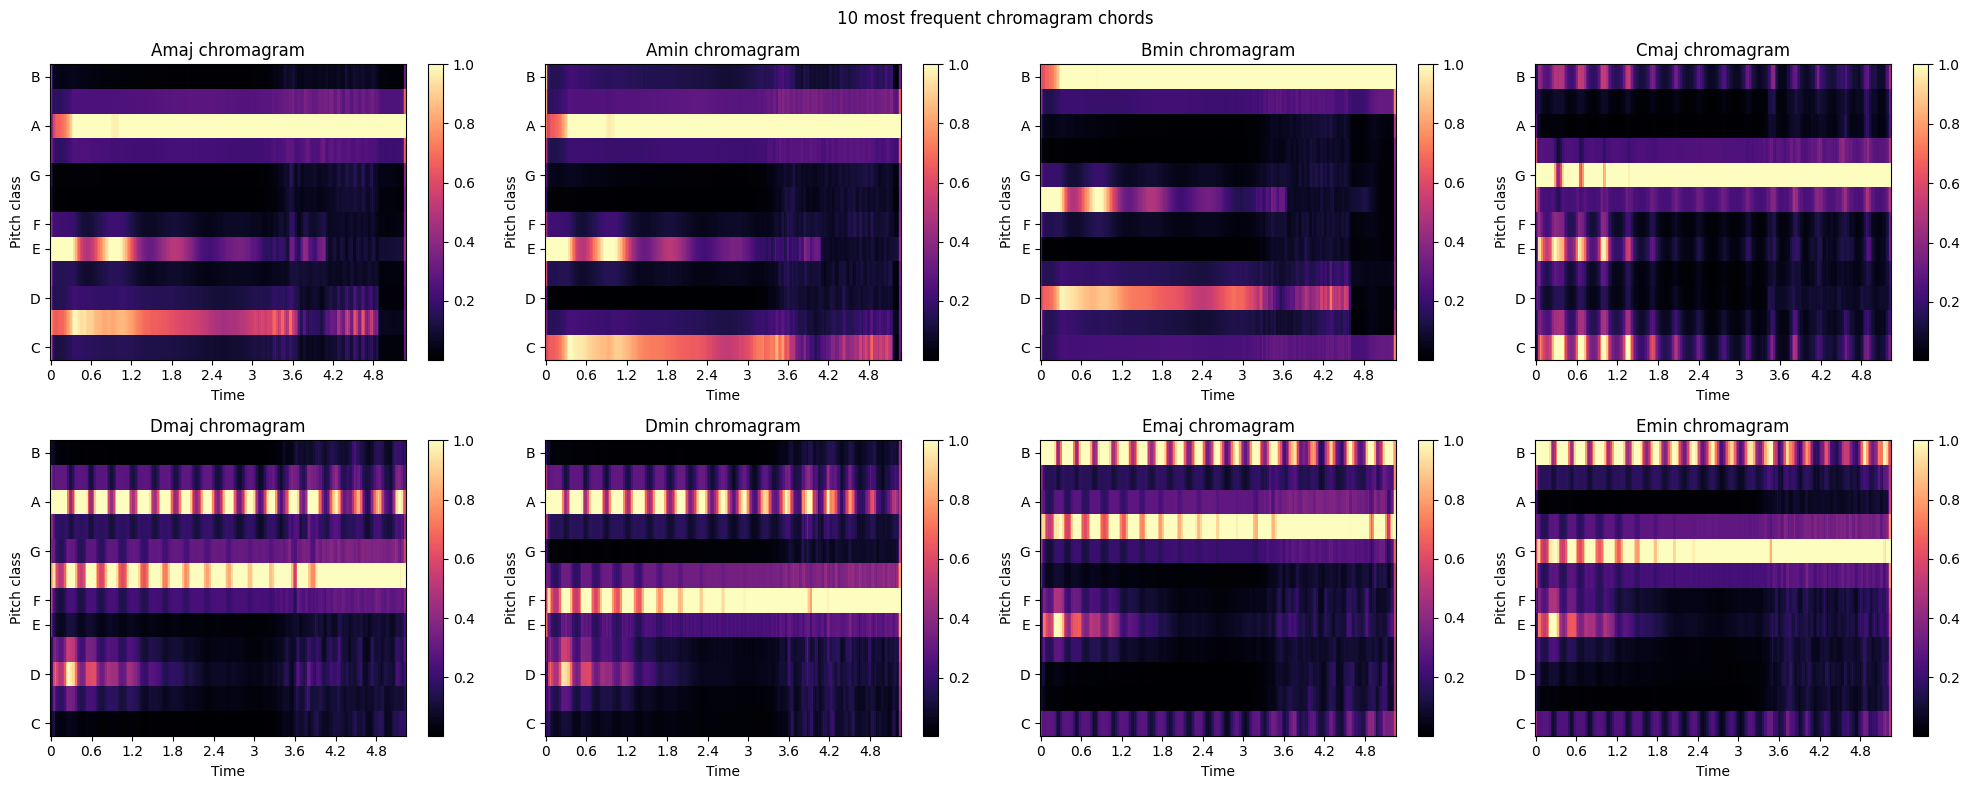

In [29]:
most_frq_chords = ['Amaj','Amin','Bmin','Cmaj','Dmaj','Dmin','Emaj','Emin','Fmaj','Gmaj']

# Crée la figure en dehors de la boucle
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i in range(2):
    for j in range(4):
        # Utilise un indice pour accéder à chaque élément de chroma
        val = chroma[i * 4 + j]
        img = librosa.display.specshow(val, y_axis='chroma', x_axis='time', ax=axes[i, j])
        fig.colorbar(img, ax=axes[i, j])
        axes[i, j].set_title(most_frq_chords[i * 4 + j] + ' chromagram')

# Ajoute des titres, labels, etc. si nécessaire
fig.suptitle('10 most frequent chromagram chords')
plt.tight_layout()
plt.show()


In [30]:
def get_feature(file_path):
 # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)

  feature = chroma_mean
  return feature

In [32]:
chroma_mean = []
for file in files:
    chroma_mean.append(get_feature(file))

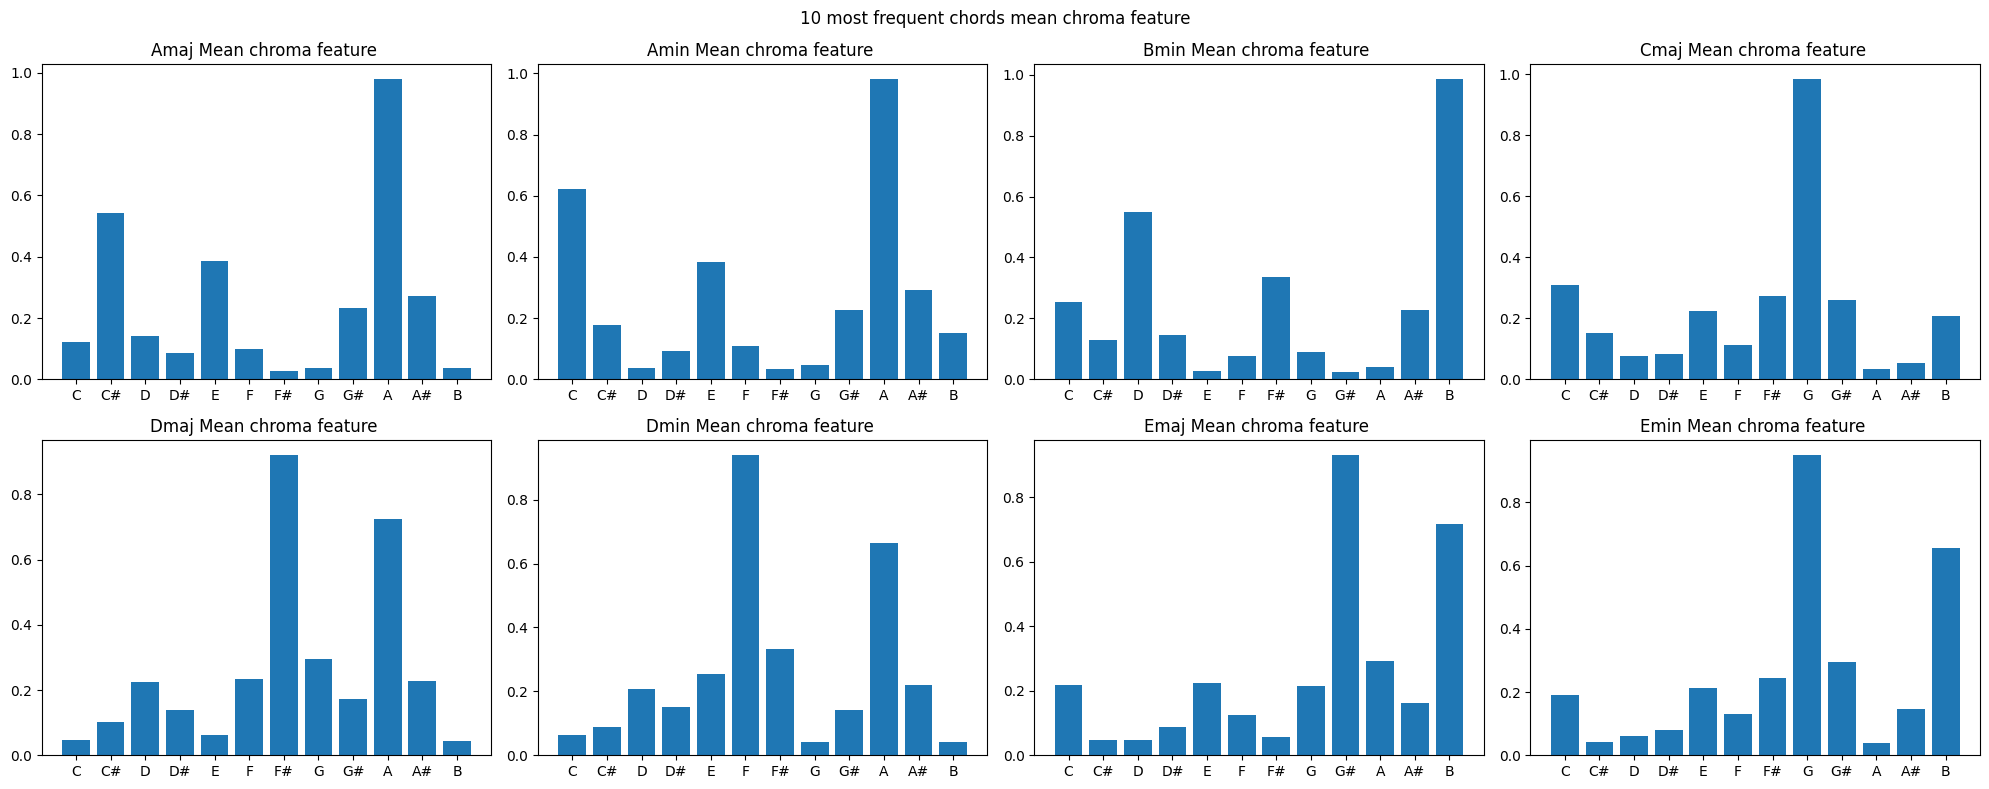

In [38]:
# Crée la figure en dehors de la boucle
names = ['C', 'C#', 'D','D#','E','F','F#','G','G#','A','A#','B'] # nom des barres
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i in range(2):
    for j in range(4):
        # Utilise un indice pour accéder à chaque ensemble de données dans chroma_data
        data = chroma_mean[i * 4 + j]

        # Crée un bar chart
        axes[i, j].bar(names, data)  # Remplace 'blue' par la couleur de ton choix

        # Ajoute des titres, labels, etc. si nécessaire
        axes[i, j].set_title(f'{most_frq_chords[i * 4 + j]} Mean chroma feature ')

# Ajoute un titre global
fig.suptitle('10 most frequent chords mean chroma feature')

# Ajuste l'espacement entre les sous-graphiques
plt.tight_layout()

# Affiche la figure entière
plt.show()


**Creation du Dataset**

In [39]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [179]:
dir = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav"
features, labels = extract_features(dir)

In [180]:
permutations = np.random.permutation(len(features))

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

features = np.array(features)[permutations]
labels_encoded = np.array(labels_encoded)[permutations]

**Réseau de Neurones**

In [181]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

In [182]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(12,)))
model.add(keras.layers.Dense(35, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [183]:
history = model.fit(X_train,y_train,epochs=50,validation_split=0.3)


Epoch 1/50
35/35 [==============================] - 1s 9ms/step - loss: 2.2761 - accuracy: 0.0830 - val_loss: 2.1664 - val_accuracy: 0.1833
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 2.0766 - accuracy: 0.4571 - val_loss: 1.9741 - val_accuracy: 0.6167
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 1.8728 - accuracy: 0.6241 - val_loss: 1.7653 - val_accuracy: 0.7042
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 1.6544 - accuracy: 0.7089 - val_loss: 1.5479 - val_accuracy: 0.7958
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 1.4359 - accuracy: 0.8089 - val_loss: 1.3374 - val_accuracy: 0.7958
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 1.2302 - accuracy: 0.8232 - val_loss: 1.1396 - val_accuracy: 0.9000
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 1.0404 - accuracy: 0.9223 - val_loss: 0.9647 - val_accuracy: 0.9000
Epoch 8/50
35/35 [==

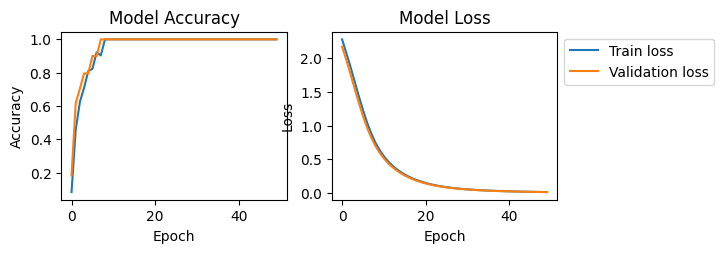

In [184]:
plt.subplot(221)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [196]:
import random

# Choisissez un exemple aléatoire dans l'ensemble de test
index = random.randint(0, len(X_test) - 1)
input_test = np.expand_dims(X_test[index], axis=0)  # Convertir en forme (1, num_features) pour une prédiction unique

# Faites la prédiction
prediction = model.predict(input_test)

classe = np.argmax(prediction)

taux_confiance = max(prediction[0]) * 100
predicted_accord_name = label_encoder.inverse_transform([classe])[0]

print(f'Prédiction de classe : {classe}')
print(f'Accord prédit : {predicted_accord_name}')
print(f'Taux de confiance : {taux_confiance}%')


1/1 [==============================] - 0s 36ms/step
Prédiction de classe : 1
Accord prédit : Amin
Taux de confiance : 99.17488098144531%


In [197]:
y_pred = model.predict(X_test)
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

count = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        count+=1

string = "Performance : " + str(count/len(y_test)*100) + "%"
print(string)


13/13 [==============================] - 0s 2ms/step
Performance : 100.0%
